In [29]:
import json
import argparse
import torch
import os

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from src.model import Model
from src.augmentation.policies import simple_augment_test
from src.utils.common import read_yaml
from src.utils.inference_utils import run_model
import matplotlib.pyplot as plt
from torch.utils.data import RandomSampler
from torchvision.transforms import transforms

CLASSES = ['Battery', 'Clothing', 'Glass', 'Metal', 'Paper', 'Paperpack', 'Plastic', 'Plasticbag', 'Styrofoam']

CLASSES_DICT = {
    0: 'Battery',
    1: 'Clothing',
    2: 'Glass',
    3: 'Metal',
    4: 'Paper',
    5: 'Paperpack',
    6: 'Plastic',
    7: 'Plasticbag',
    8: 'Styrofoam'
}

In [ ]:
# !pwd

In [2]:
# %cd pstage4gun

/opt/ml/pstage4gun


In [4]:
model_config = 'configs/model/mobilenetv3.yaml'
weight = 'exp/2021-05-25_14-36-26/best.pt'
img_root_val = '/opt/ml/input/data/val/'
img_root_test = '/opt/ml/input/data/test/'
data_config = 'configs/data/taco.yaml'

In [5]:
invTrans = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.],
                                                        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                   transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                                        std=[1., 1., 1.]),
                                   ])

In [6]:
class CustomImageFolder(ImageFolder):
    """ImageFolder with filename."""

    def __getitem__(self, index):
        img_gt = super(CustomImageFolder, self).__getitem__(index)
        fdir = self.imgs[index][0]
        fname = fdir.rsplit(os.path.sep, 1)[-1]
        return (img_gt + (fname,))

In [27]:
def get_dataloader_random(img_root: str, data_config: str, img_type:str) -> DataLoader:
    """Get dataloader.

    Note:
	Don't forget to set normalization.
    """
    # Load yaml
    data_config = read_yaml(data_config)

    transform_test_args = data_confg["AUG_TEST_PARAMS"] if data_config.get("AUG_TEST_PARAMS") else None
    # Transformation for test
    transform_test = getattr(
        __import__("src.augmentation.policies", fromlist=[""]),
        data_config["AUG_TEST"],
    )(dataset=data_config["DATASET"], img_size=data_config["IMG_SIZE"])

    if img_type in ('train','val'):
        dataset = ImageFolder(root=img_root, transform=transform_test)
    elif img_type == 'test':
        dataset = CustomImageFolder(root=img_root, transform=transform_test)
    else:
        AssertionError('type train or val or test')
    data_sampler = RandomSampler(dataset)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=16,
        num_workers=8,
        sampler=data_sampler
    )
    return dataloader

In [32]:
def EDA_val(model, img_root, data_config):

    # prepare datalaoder
    val_loader = get_dataloader_random(img_root=img_root, data_config=data_config, img_type='val')

    model = model.to(device)
    model.eval()

    fig, axes = plt.subplots(4,4, figsize=(15,15))

    axes = axes.flatten()
    for img, labels in val_loader:
        img = img.to(device)
        pred, _ = run_model(model, img)
        pred = torch.argmax(pred, dim=-1)
        print(labels)
        print(pred)
        img = img.cpu()
        for i in range(16):
            axes[i].imshow(invTrans(img[i]).permute([1, 2, 0]))
            axes[i].set_title(
                f"label : {labels[i]} {CLASSES_DICT[int(labels[i])]} \n"
                f"predict : {pred[i]} {CLASSES_DICT[int(pred[i])]}" , fontsize=12)
        break

In [33]:
def EDA_test(model, img_root, data_config):

    # prepare datalaoder
    test_loader = get_dataloader_random(img_root=img_root, data_config=data_config, img_type='test')

    model = model.to(device)
    model.eval()

    fig, axes = plt.subplots(4,4, figsize=(15,15))

    axes = axes.flatten()
    for img, _, fname in test_loader:
        img = img.to(device)
        pred, _ = run_model(model, img)
        pred = torch.argmax(pred, dim=-1)

        img = img.cpu()
        for i in range(16):
            axes[i].imshow(invTrans(img[i]).permute([1, 2, 0]))
            axes[i].set_title(f"predict : {pred[i]} {CLASSES_DICT[int(pred[i])]}", fontsize=12)
        break

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# prepare model
model_instance = Model(model_config, verbose=True)
model_instance.model.load_state_dict(torch.load(weight, map_location=torch.device('cpu')))

idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResidual

<All keys matched successfully>

tensor([4, 6, 7, 6, 2, 8, 6, 7, 6, 7, 4, 2, 4, 0, 8, 4])
tensor([7, 4, 4, 5, 7, 7, 4, 2, 2, 7, 7, 7, 2, 7, 7, 7], device='cuda:0')


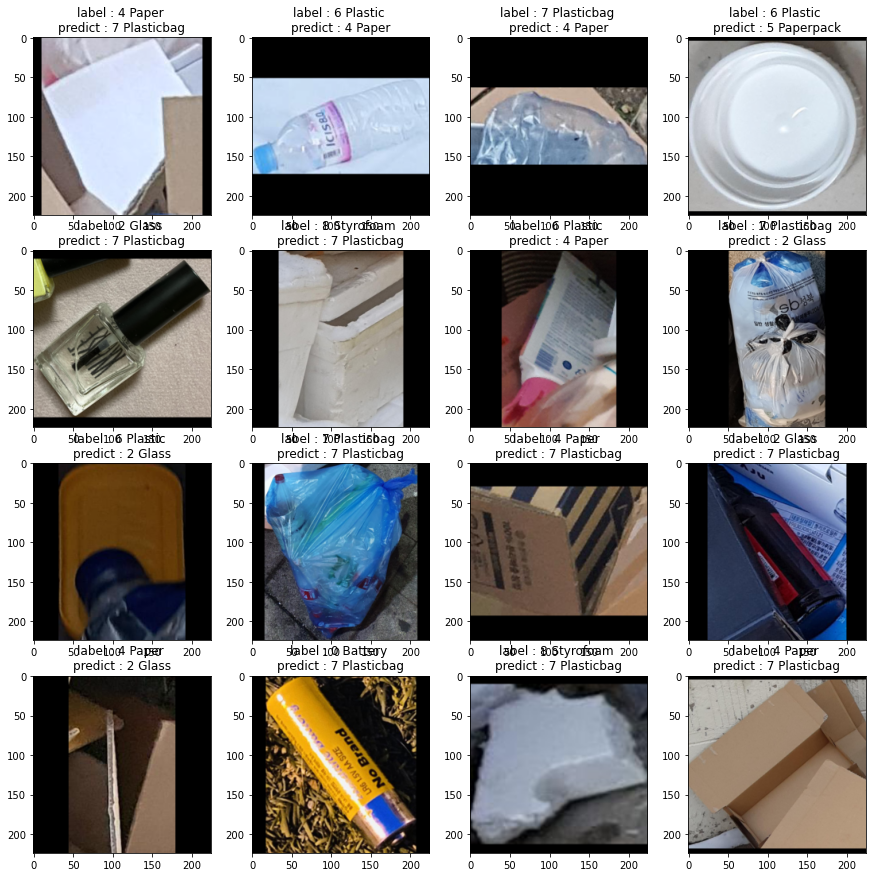

In [35]:
EDA_val(model_instance.model, img_root_val, data_config)

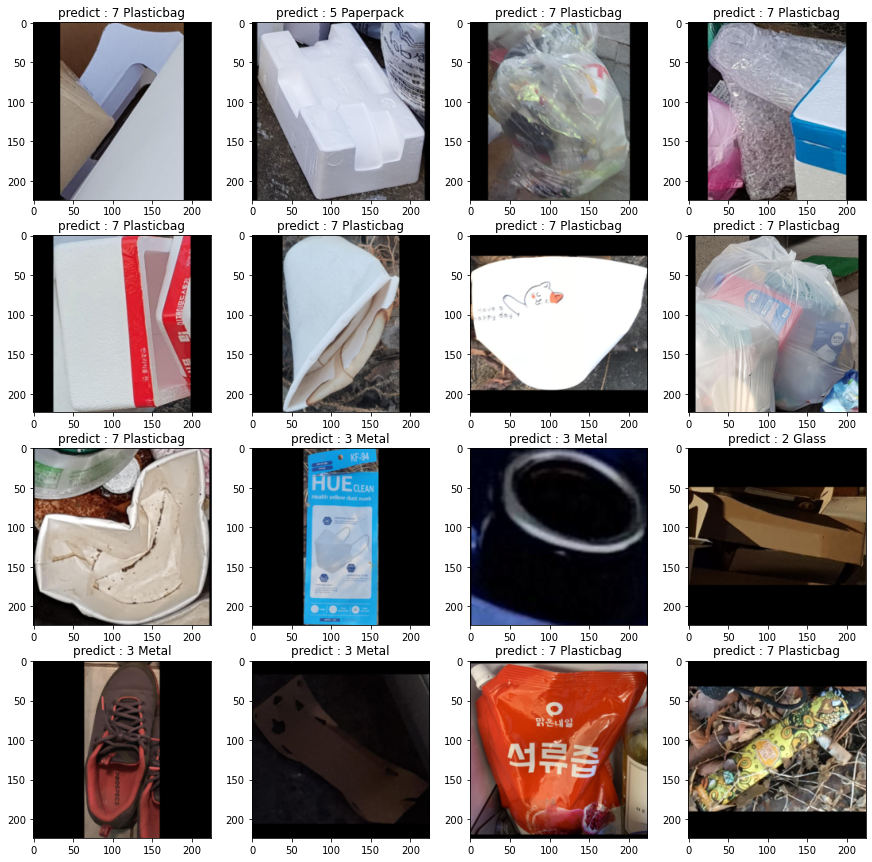

In [36]:
# inference
EDA_test(model_instance.model, img_root_test, data_config)